Data loaded and split successfully.
Probability model training rows: 174734
Severity model training rows (claimed policies): 524
Transforming data using preprocessor...
Training Probability Model (native xgboost)...
Probability Model AUC on test set: 0.8709
Training Severity Model (native xgboost)...
Severity Model R-squared on severity test set: -0.0871

--- Probability Model Evaluation ---


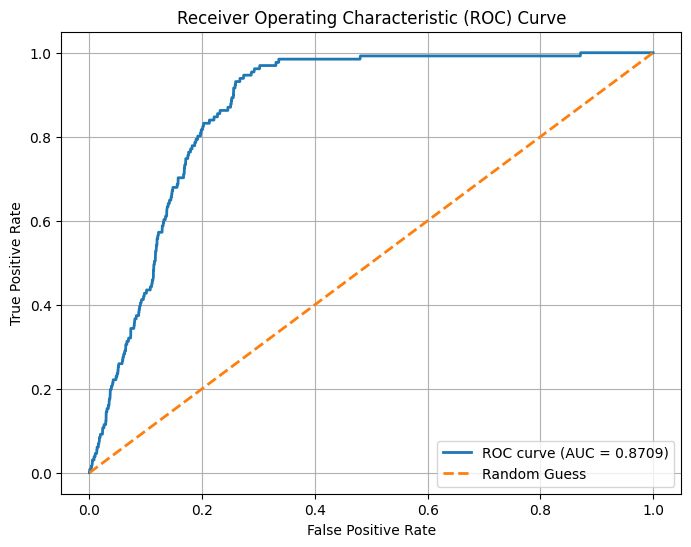


--- SHAP Analysis for Claim Severity Model ---
SHAP Summary Plot (Overall Feature Importance)


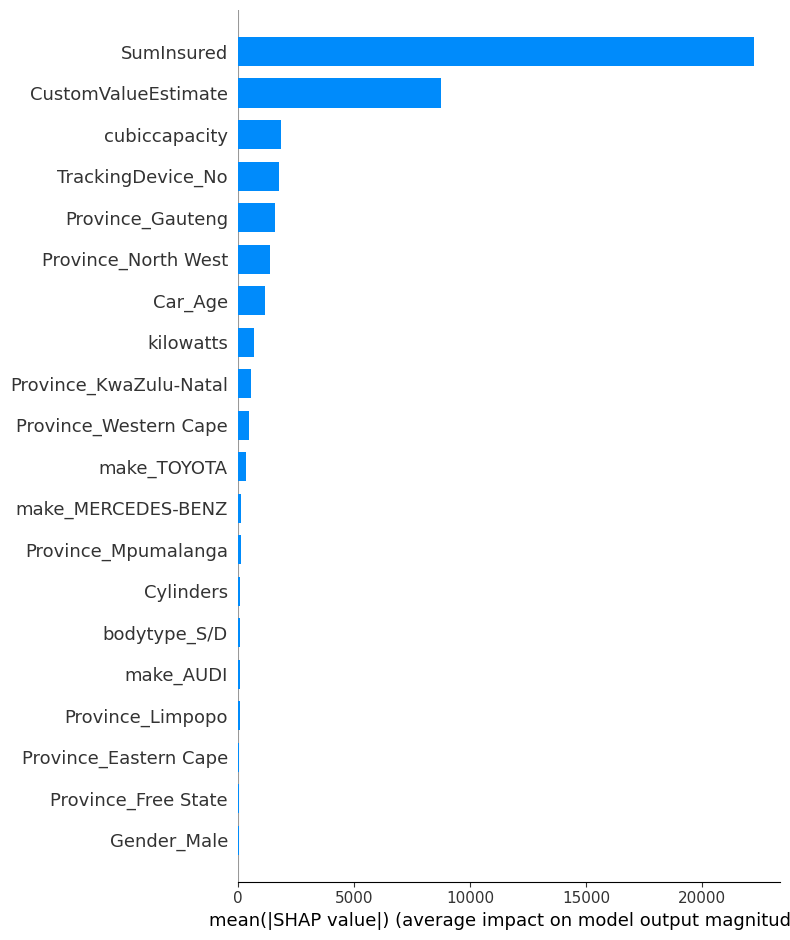


SHAP Dependence Plot for SumInsured


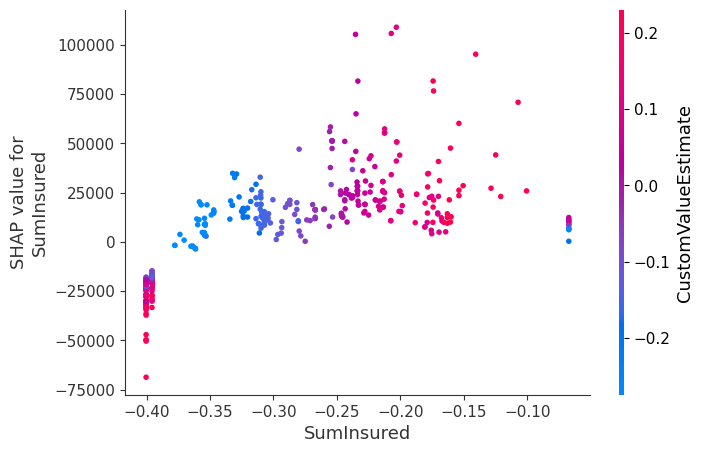

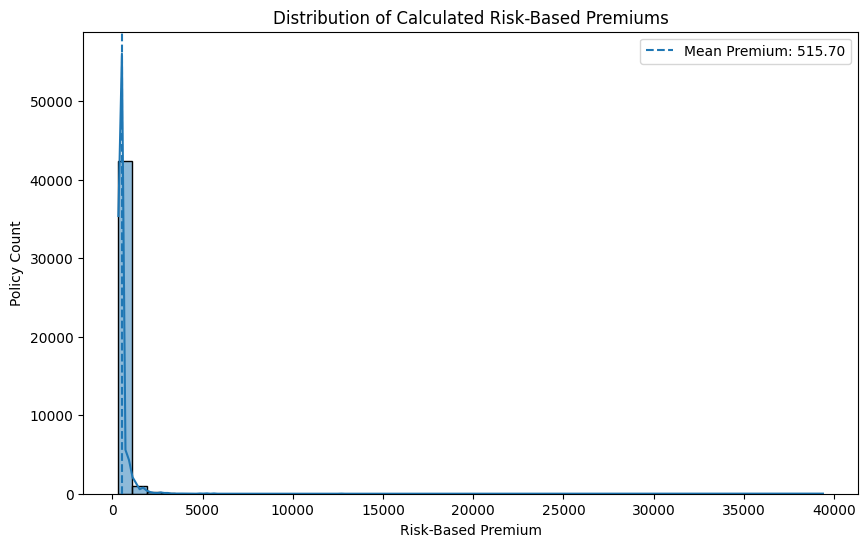


Sample of Final Premiums:
   Pure_Premium  Risk_Based_Premium
0      0.172189          434.969757
1      0.468718          435.292084
2      0.552353          435.382965
3      0.171556          434.969086
4      1.006505          435.876617

Summary Statistics for Risk-Based Premium:
count    43684.000000
mean       515.703247
std        443.407715
min        339.047028
25%        435.300018
50%        436.101227
75%        453.851166
max      39375.398438
Name: Risk_Based_Premium, dtype: float64


In [60]:
"""
Corrected end-to-end script:
 - fixes data-split return values and variable name mismatches
 - avoids repeated mutation of feature lists
 - uses XGBoost native booster consistently with DMatrix
 - uses the correct prediction APIs (bst.predict for native boosters)
 - prepares feature names for SHAP after OneHotEncoding
 - avoids calling predict_proba on native xgboost boosters
"""

# --- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import shap

# --- Configuration ---
DATA_PATH = '../data/MachineLearningRating_v3.txt'
DATA_SEP = '|'

# NOTE: define base lists here but do NOT mutate them in functions (avoid side-effects)
BASE_NUMERICAL_FEATURES = ['Cylinders', 'cubiccapacity', 'kilowatts', 'CustomValueEstimate', 'SumInsured']
BASE_CATEGORICAL_FEATURES = ['Province', 'Gender', 'make', 'VehicleType', 'bodytype', 'AlarmImmobiliser', 'TrackingDevice']

# --- Define Preprocessor ---
def create_preprocessor(num_feats, cat_feats):
    """Preprocessing: scale numericals and one-hot encode categoricals."""
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_feats),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
        ],
        remainder='drop'
    )

# --- Load and Split Data ---
def load_and_split_data(file_path, sep, numerical_features, categorical_features):
    """
    Loads data, creates Car_Age if RegistrationYear exists, builds claim targets,
    and returns train/test sets for both probability and severity models.
    IMPORTANT: This function avoids mutating the caller's feature lists.
    """
    df = pd.read_csv(file_path, sep=sep, low_memory=False)

    # Work on copies of feature lists so caller's lists don't get mutated
    num_feats = list(numerical_features)
    cat_feats = list(categorical_features)

    # Feature engineering: Car_Age (only add if RegistrationYear present and not already added)
    if 'RegistrationYear' in df.columns:
        # Use a fixed reference year as in original (2015-08-01 -> year 2015)
        df['Car_Age'] = 2015 - df['RegistrationYear']
        if 'Car_Age' not in num_feats:
            num_feats.append('Car_Age')

    # Create binary claim indicator
    if 'TotalClaims' not in df.columns:
        raise KeyError("Expected column 'TotalClaims' in data.")
    df['Claim_Indicator'] = np.where(df['TotalClaims'] > 0, 1, 0)

    # Keep rows which have required features and targets
    X_cols = num_feats + cat_feats
    required_cols = X_cols + ['TotalClaims', 'Claim_Indicator']
    df_clean = df.dropna(subset=required_cols).copy()

    X = df_clean[X_cols]
    y_prob = df_clean['Claim_Indicator']

    # Probability model split (stratify by label)
    X_train_prob, X_test_prob, y_train_prob, y_test_prob = train_test_split(
        X, y_prob, test_size=0.2, random_state=42, stratify=y_prob
    )

    # Severity: only rows with claims (Claim_Indicator == 1)
    df_sev = df_clean[df_clean['Claim_Indicator'] == 1]
    X_sev = df_sev[X_cols]
    y_sev = df_sev['TotalClaims']

    X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
        X_sev, y_sev, test_size=0.2, random_state=42
    )

    # return explicit and intuitive ordering
    return (X_train_prob, X_test_prob, y_train_prob, y_test_prob,
            X_train_sev, X_test_sev, y_train_sev, y_test_sev, num_feats, cat_feats)


# --- EXECUTE LOAD AND PREPROCESS ---
(X_train_prob, X_test_full, y_train_prob, y_test_prob,
 X_train_sev, X_test_sev, y_train_sev, y_test_sev,
 numerical_features, categorical_features) = load_and_split_data(
    DATA_PATH, DATA_SEP, BASE_NUMERICAL_FEATURES, BASE_CATEGORICAL_FEATURES
)

preprocessor = create_preprocessor(numerical_features, categorical_features)

print("Data loaded and split successfully.")
print(f"Probability model training rows: {len(X_train_prob)}")
print(f"Severity model training rows (claimed policies): {len(X_train_sev)}")

# --- 0. Transform Data using preprocessor (outside pipeline) ---
print("Transforming data using preprocessor...")
# Fit on probability training (it contains all policies and both num+cat)
X_train_prob_transformed = preprocessor.fit_transform(X_train_prob)
X_test_full_transformed = preprocessor.transform(X_test_full)
X_train_sev_transformed = preprocessor.transform(X_train_sev)
X_test_sev_transformed = preprocessor.transform(X_test_sev)

# --- 1. Train Claim Probability Model (Native XGBoost) ---
print("Training Probability Model (native xgboost)...")
dtrain_prob = xgb.DMatrix(X_train_prob_transformed, label=y_train_prob)
dtest_prob = xgb.DMatrix(X_test_full_transformed)

params_prob = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'seed': 42,
    'nthread': -1
}

bst_prob = xgb.train(params_prob, dtrain_prob, num_boost_round=100)

# Predict probabilities using native booster (bst.predict returns probabilities for binary:logistic)
y_pred_proba = bst_prob.predict(dtest_prob)
print(f"Probability Model AUC on test set: {roc_auc_score(y_test_prob, y_pred_proba):.4f}")

# --- 2. Train Claim Severity Model (Native XGBoost) ---
print("Training Severity Model (native xgboost)...")
dtrain_sev = xgb.DMatrix(X_train_sev_transformed, label=y_train_sev)
dtest_sev = xgb.DMatrix(X_test_sev_transformed)

params_sev = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'seed': 42,
    'nthread': -1
}

bst_sev = xgb.train(params_sev, dtrain_sev, num_boost_round=100)

y_pred_sev = bst_sev.predict(dtest_sev)
print(f"Severity Model R-squared on severity test set: {r2_score(y_test_sev, y_pred_sev):.4f}")

# Keep native boosters accessible
xgb_prob_model = bst_prob
xgb_sev_model = bst_sev

# --- 3. Evaluation and SHAP Interpretation ---

# A. ROC Curve (Probability Model)
print("\n--- Probability Model Evaluation ---")
auc_roc = roc_auc_score(y_test_prob, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test_prob, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# B. SHAP for Severity Model
print("\n--- SHAP Analysis for Claim Severity Model ---")
# Build feature names: numerical + OHE feature names
ohe = preprocessor.named_transformers_['cat']
# get_feature_names_out requires passing the input feature names
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numerical_features + ohe_feature_names

# Use TreeExplainer with native booster
explainer = shap.TreeExplainer(xgb_sev_model)
# For speed, compute SHAP on the training set used for severity (array is fine)
shap_values = explainer.shap_values(X_train_sev_transformed)

# Summary plot (bar)
print("SHAP Summary Plot (Overall Feature Importance)")
shap.summary_plot(shap_values, features=X_train_sev_transformed, feature_names=all_feature_names, plot_type="bar")
plt.show()

# Dependence plot for one numeric feature (SumInsured)
if 'SumInsured' in all_feature_names:
    idx = all_feature_names.index('SumInsured')
    print("\nSHAP Dependence Plot for SumInsured")
    shap.dependence_plot(idx, shap_values, X_train_sev_transformed, feature_names=all_feature_names)
    plt.show()
else:
    print("SumInsured not found in feature names; skipping dependence plot.")

# --- 4. Final Premium Analysis and Distribution ---

# We want predicted severity for **all policies** in the full test set.
# NOTE: severity model was trained only on claims; predicting severity for all policies is valid as "predicted severity"
dtest_full_for_sev = xgb.DMatrix(X_test_full_transformed)

predicted_severity_for_all = xgb_sev_model.predict(dtest_full_for_sev)  # reg model -> numeric
predicted_prob_for_all = xgb_prob_model.predict(dtest_prob)  # dtest_prob is xgb.DMatrix for X_test_full_transformed

# Pure Premium (Expected Loss)
pure_premium = predicted_prob_for_all * predicted_severity_for_all

# Business parameters
EXPENSE_LOADING = 400.00
PROFIT_MARGIN = 0.08

risk_based_premium = (pure_premium + EXPENSE_LOADING) / (1 - PROFIT_MARGIN)

results_df = pd.DataFrame({
    'Predicted_Prob': predicted_prob_for_all,
    'Predicted_Severity': predicted_severity_for_all,
    'Pure_Premium': pure_premium,
    'Risk_Based_Premium': risk_based_premium
})

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Risk_Based_Premium'], bins=50, kde=True)
plt.title('Distribution of Calculated Risk-Based Premiums')
plt.xlabel('Risk-Based Premium')
plt.ylabel('Policy Count')
plt.axvline(results_df['Risk_Based_Premium'].mean(), linestyle='--', label=f'Mean Premium: {results_df["Risk_Based_Premium"].mean():.2f}')
plt.legend()
plt.show()

print("\nSample of Final Premiums:")
print(results_df[['Pure_Premium', 'Risk_Based_Premium']].head())
print(f"\nSummary Statistics for Risk-Based Premium:\n{results_df['Risk_Based_Premium'].describe()}")
